# OOD Detection Pipeline

## 1. Load data to obtain hidden representations.

### Datasets

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from constants import JORDAN_DATASET_FILEPATH, OOD_DATASET_FILEPATH
from data.jordan_dataset import JordanDataset
from data.ood_dataset import MaestroDataset


print("Loading Jordan dataset - train")
id_train_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train"
)
print(f"Obtained {len(id_train_dataset)} training examples from Jordan dataset - train")

print("Loading Jordan dataset - test")
id_test_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation"
)
print(f"Obtained {len(id_test_dataset)} testing examples from Jordan dataset - test")

print("Loading Maestro dataset - test")
ood_dataset = MaestroDataset(
    # data_dir=OOD_DATASET_FILEPATH,
    data_dir="/scratch/joel/maestrodata",
    split="test"
)
print(f"Obtained {len(ood_dataset)} testing examples from Maestro dataset - test")

/home/rjloh/jambot_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Jordan dataset - train
Loading train split from /scratch/rjloh/jordan_dataset...
Loaded 4060 samples from train split
Sample keys: ['input_ids', 'labels']
Skipped 490 bad samples
Obtained 4060 training examples from Jordan dataset - train
Loading Jordan dataset - test
Loading validation split from /scratch/rjloh/jordan_dataset...
Loaded 84 samples from validation split
Sample keys: ['input_ids', 'labels']
Skipped 0 bad samples
Obtained 84 testing examples from Jordan dataset - test
Loading Maestro dataset - test
path /scratch/joel/maestrodata/test.txt
Obtained 962 testing examples from Maestro dataset - test


### Model

In [ ]:
from constants import DEVICE, JORDAN_MODEL_NAME
import torch
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    JORDAN_MODEL_NAME
)

model = model.to(torch.float32).to(DEVICE)

### Extract layers

In [6]:
from extract_layers.pooling_functions import pool_mean_std

batch_size = 8
n_layers = 24
pooling_function = pool_mean_std

layers_to_extract = list(range(n_layers + 1))

### Extract representations: run this only once

In [ ]:
# from constants import SCRATCH_FILEPATH
# from torch.utils.data import DataLoader
# from utils.data_loading import collate_fn
# from extract_layers.extract_layers_main import extract_representations

# for dataset_name, dataset in [("id_train_dataset", id_train_dataset), ("id_test_dataset", id_test_dataset), ("ood_dataset", ood_dataset)]:
#     print(f"Creating {dataset_name} dataloader")
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#     print(f"Extracting representations from {dataset_name} dataloader")
#     save_dir = f"{SCRATCH_FILEPATH}/{dataset_name}"
#     extract_representations(
#         model,
#         dataloader,
#         pooling_function=pooling_function,
#         save_dir=save_dir,
#         layers=layers_to_extract,
#     )


# 2. OOD Detector

Refer to [OOD detection docs](../../docs/ood_detection.md) for more information about this.

In [8]:
from main.transformations import Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from main.scoring_functions import mahalanobis_distance

transformations = Transformations(
    [
        PCA(n_components=10),
        StandardScaler(),
    ]
) # this is IN ADDITION to the extraction done in extract_layers.py
scoring_function = mahalanobis_distance

### Retrieve extracted data from files

In [9]:
from constants import SCRATCH_FILEPATH
import numpy as np

layer_idx = 8
num_test_samples = 50   

id_train_data = np.load(f"{SCRATCH_FILEPATH}/id_train_dataset/layer_{layer_idx}.npy")
id_test_data = np.load(f"{SCRATCH_FILEPATH}/id_test_dataset/layer_{layer_idx}.npy")[:num_test_samples, :]
ood_data = np.load(f"{SCRATCH_FILEPATH}/ood_dataset/layer_{layer_idx}.npy")[:num_test_samples, :]

print("Obtained hidden layer activations from files")
print("ID train data shape:", id_train_data.shape)
print("ID test data shape:", id_test_data.shape)
print("OOD data shape:", ood_data.shape)


Obtained hidden layer activations from files
ID train data shape: (4060, 2048)
ID test data shape: (50, 2048)
OOD data shape: (50, 2048)


## Create OOD detector
from transformations and scoring function

In [ ]:
import importlib
import ood_detector

importlib.reload(ood_detector)
from ood_detector import OODDetector

ood_detector = OODDetector(
    embedding_function=transformations,
    scoring_function=scoring_function,
    id_train_data=id_train_data,
)

We can evaluate the detector!

```threshold = 0.7``` with ```threshold_type = "percentile"``` means that the score threshold is set to be the 70th percentile of all the scores (ID test + OOD test combined).

In [65]:
confusion_matrix, true_positive_rate, false_positive_rate = ood_detector.evaluate(
    id_test_data,
    ood_data,
    threshold=0.7,
    threshold_type="percentile",
)
print("Confusion matrix:", confusion_matrix)
print("True positive rate:", true_positive_rate)
print("False positive rate:", false_positive_rate)


Confusion matrix: tensor([[30, 20],
        [ 0, 50]])
True positive rate: tensor(0.6000)
False positive rate: tensor(0.)


We can plot the ROC curve and get AUROC!

AUROC will appear as ```main/auroc.png```

/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail

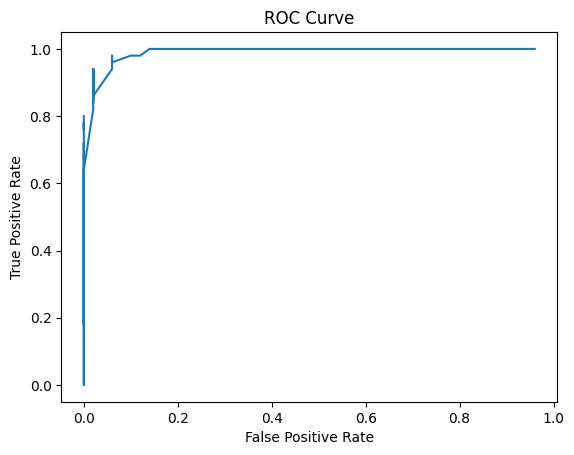

In [66]:
import importlib
import eval.auroc

importlib.reload(eval.auroc)
from eval.auroc import get_auroc

auroc = get_auroc(
    ood_detector,
    id_test_data,
    ood_data,
)

THIS IS SO SUS i think it needs to be debugged...

In [67]:
print("AUROC:", auroc)



AUROC: 0.9487999677658081


Test with ID data to see if AUROC is very low.

/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail.mit.edu/u/r/rjloh/ood-detection/src/main/ood_detector.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_scores, torch.tensor(threshold, dtype=all_scores.dtype)
/afs/csail

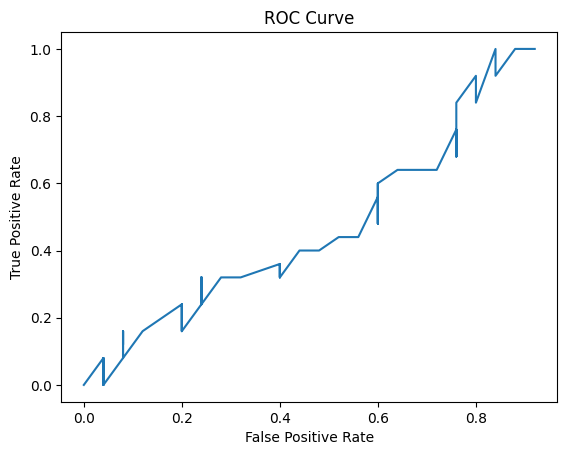

Sanity check AUROC (ID vs ID): 0.422


In [68]:
# split ID test data in half
n = len(id_test_data) // 2
id_test_A = id_test_data[:n]
id_test_B = id_test_data[n:]

auroc = get_auroc(
    ood_detector,
    id_test_A,
    id_test_B,
)
print(f"Sanity check AUROC (ID vs ID): {auroc:.3f}")
# should be around 0.5 from random overlap